# Segment Anything Model (SAM) Threshold Segmentation

### Model Installation

In [19]:
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions

!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-qf8lgqx6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-qf8lgqx6
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


### Importing Libraries

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

### Data Loading and Preprocessing

In [50]:
import os
import numpy as np
from PIL import Image

# Define directories
train_image_dir = '/kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images'
train_mask_dir = '/kaggle/input/masks-dataset/Segmented Data/Train'

# Function to load images and masks
def load_images_and_masks(image_dir, mask_dir):
    all_img_data = []
    all_mask_data = []

    # Collect all image and mask paths
    image_paths = []
    mask_paths = []

    # Loop over the folder names in the image directory
    for folder_name in os.listdir(image_dir):
        image_folder_path = os.path.join(image_dir, folder_name)
        mask_folder_path = os.path.join(mask_dir, folder_name)

        if os.path.isdir(image_folder_path) and os.path.isdir(mask_folder_path):
            # Get the list of image and mask files in the folder
            image_files = sorted(os.listdir(image_folder_path))  # Sort image files
            mask_files = sorted(os.listdir(mask_folder_path))  # Sort mask files

            # Add the paths for all images and their corresponding masks
            for image_file, mask_file in zip(image_files, mask_files):  # Match image and mask filenames
                image_path = os.path.join(image_folder_path, image_file)
                mask_path = os.path.join(mask_folder_path, mask_file)
                image_paths.append(image_path)
                mask_paths.append(mask_path)

    print(f"Total image paths: {len(image_paths)}")
    print(f"Total mask paths: {len(mask_paths)}")

    # Load each image and its corresponding mask
    for image_path, mask_path in zip(image_paths, mask_paths):
        # Read images and masks using PIL and convert them to grayscale
        image = np.array(Image.open(image_path).convert('L'))  # Convert image to grayscale
        mask = np.array(Image.open(mask_path).convert('L'))   # Convert mask to grayscale

        # Check if the mask is empty (contains only zeros)
        if np.count_nonzero(mask) > 0:  # Mask has non-zero values
            all_img_data.append(image)
            all_mask_data.append(mask)

    # Convert lists to numpy arrays
    all_img_data = np.array(all_img_data)
    all_mask_data = np.array(all_mask_data)

    print(f"Total images loaded: {all_img_data.shape}")
    print(f"Total masks loaded: {all_mask_data.shape}")

    # Ensure both image and mask data arrays are aligned
    assert len(all_img_data) == len(all_mask_data), "Mismatch in the number of images and masks!"

    return all_img_data, all_mask_data

# Load training data
train_images, train_masks = load_images_and_masks(train_image_dir, train_mask_dir)
print(f"Training images loaded: {train_images.shape}")
print(f"Training masks loaded: {train_masks.shape}")


Total image paths: 1320
Total mask paths: 1320
Total images loaded: (1320, 256, 256)
Total masks loaded: (1320, 256, 256)
Training images loaded: (1320, 256, 256)
Training masks loaded: (1320, 256, 256)


In [22]:
patch_size = 256
step = 256

In [23]:
all_img_patches = []
for img in range(train_images.shape[0]):
    large_image = train_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(train_masks.shape[0]):
    large_mask = train_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

#### Filtering empty masks

In [24]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (1320, 256, 256)
Mask shape: (1320, 256, 256)


##### Training Dataset

In [25]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [26]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1320
})

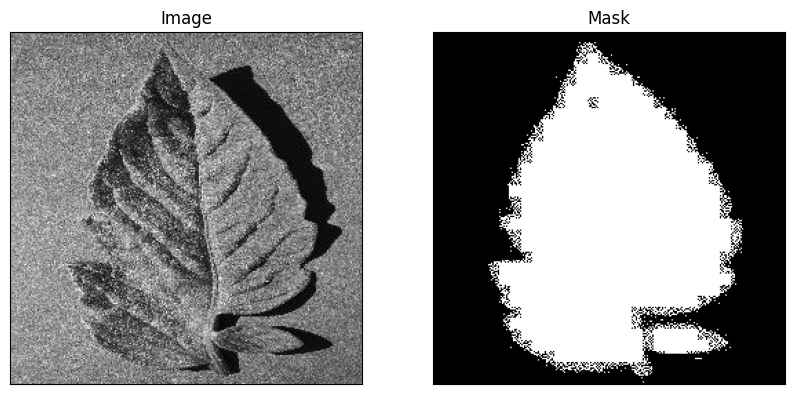

In [66]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

### Model Implementation

In [46]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [74]:
from PIL import Image
import numpy as np

class SAMDataset(Dataset):
    """
    This class is used to create a dataset that serves input images and masks.
    It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
    """
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        ground_truth_mask = np.array(item["label"])

        # Convert PIL image to NumPy array
        image = np.array(image)

        # Convert grayscale image (2D) to RGB by duplicating the channel
        if len(image.shape) == 2:  # Grayscale image (height, width)
            image = np.stack([image] * 3, axis=-1)  # Convert to (height, width, 3)

        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs


In [76]:
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [77]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [78]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


### Train Data Loader

In [79]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [80]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [81]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [82]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# Freeze vision encoder and prompt encoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

### Defining Loss function and Optimizer

In [83]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

### Model Training

In [84]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import numpy as np

# Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    epoch_accuracies = []  # List to store accuracies for each batch
    epoch_ious = []  # List to store IoU values for each batch

    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()
        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

        # Compute pixel-wise accuracy
        predicted_mask_bin = (predicted_masks > 0.5).float()  # Binarize the prediction (adjust threshold if needed)
        pixel_accuracy = (predicted_mask_bin == ground_truth_masks).float().mean().item()

        # Compute IoU (Intersection over Union)
        intersection = torch.sum(predicted_mask_bin * ground_truth_masks)
        union = torch.sum(predicted_mask_bin) + torch.sum(ground_truth_masks) - intersection
        iou = intersection / (union + 1e-6)  # Add small epsilon to avoid division by zero

        # Store accuracy and IoU for this batch
        epoch_accuracies.append(pixel_accuracy)
        epoch_ious.append(iou.item())

    # Calculate mean accuracy and IoU for the epoch
    mean_accuracy = mean(epoch_accuracies)
    mean_iou = mean(epoch_ious)

    # Print the results for this epoch
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    print(f'Mean pixel-wise accuracy: {mean_accuracy * 100:.2f}%')
    print(f'Mean IoU: {mean_iou:.4f}')


100%|██████████| 660/660 [11:23<00:00,  1.04s/it]

EPOCH: 0
Mean loss: 0.24324197495977085
Mean pixel-wise accuracy: 82.59%
Mean IoU: 5.0603


In [85]:
torch.save(model.state_dict(), "/kaggle/working/mito_model_checkpoint.pth")

In [86]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [87]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/kaggle/working/mito_model_checkpoint.pth"))
     

/tmp/ipykernel_248/3645407344.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_mito_model.load_state_dict(torch.load("/kaggle/working/mito_model_checkpoint.pth"))


<All keys matched successfully>

In [88]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

### Model Testing

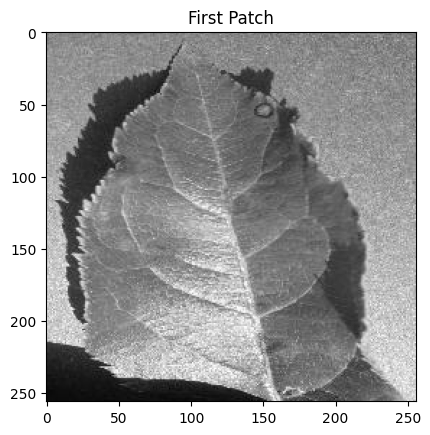

In [99]:
from PIL import Image
import numpy as np
from patchify import patchify
import matplotlib.pyplot as plt

# Load an image from your project directory
image_path = "/kaggle/input/cv25-project-dataset/Project Data/Project Data/Val/images/Apple___Apple_scab/2bfd8ee0-af6b-42fd-ae61-fc5e92ec1b67___FREC_Scab 2988.JPG"  # Replace with the correct path to your image
test_image = Image.open(image_path)

# Convert the image to grayscale
test_image = test_image.convert('L')  # 'L' mode for grayscale

# Convert the image to a numpy array (if needed)
test_image_np = np.array(test_image)

# Ensure the image is 2D (height, width) for grayscale
if len(test_image_np.shape) == 3:  # Check if it's RGB
    test_image_np = np.mean(test_image_np, axis=-1).astype(np.uint8)  # Convert to grayscale by averaging channels

# Create patches with the specified size and step
patches = patchify(test_image_np, (256, 256), step=256)  # Step=256 for 256 patches means no overlap

# Example: Access the first patch
first_patch = patches[0, 0]  # Example: First patch in the grid

# Remove the extra batch dimension (if any) by squeezing
first_patch = first_patch.squeeze()

# Show the first patch
plt.imshow(first_patch, cmap='gray')  # Use cmap='gray' for grayscale images
plt.title("First Patch")
plt.show()


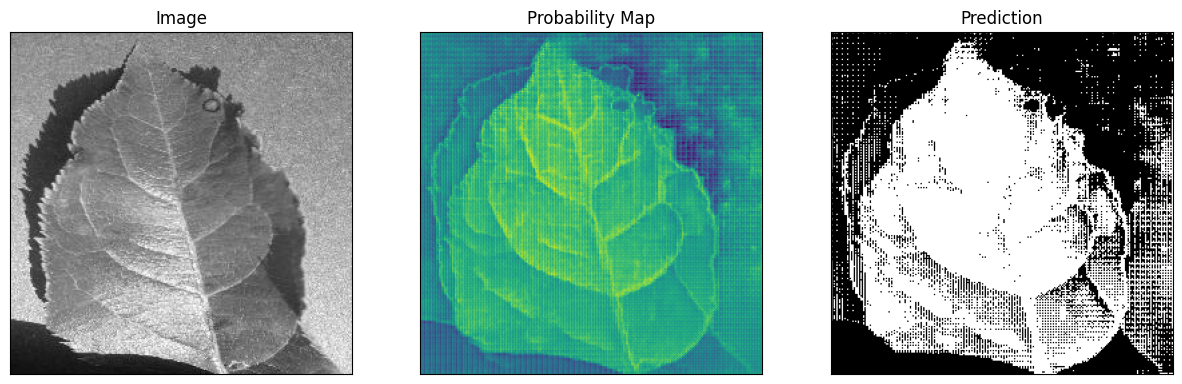

In [102]:
# Select the only patch available at index [0, 0]
random_array = patches[0, 0]  # Since the shape is (1, 1, 256, 256), index (0, 0) is valid

# Convert the array to an image
single_patch = Image.fromarray(random_array)

# Convert the image to RGB (if it's grayscale)
single_patch_rgb = single_patch.convert("RGB")

# Prepare the image for the model (using input points if necessary)
inputs = processor(single_patch_rgb,  return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
my_mito_model.eval()

# Perform forward pass with no gradients
with torch.no_grad():
  outputs = my_mito_model(**inputs, multimask_output=False)

# Apply sigmoid function to get probabilities
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

# Convert the soft mask to a hard mask (binary mask)
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)

# Create subplots to display the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image on the left
axes[0].imshow(np.array(single_patch_rgb))
axes[0].set_title("Image")

# Plot the probability map in the middle
axes[1].imshow(single_patch_prob)
axes[1].set_title("Probability Map")

# Plot the final prediction on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels for better visualization
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()
